# IBM Data Science Capstone Project Notebook

**Author : Tennyson Wu**

## Table of Contents

1. [Introduction](#s1)
2. [Libraries](#s2)
3. [Data Collection and Preprocessing](#s3)
4. [Data Preparation](#s4)
5. [K-Means Clustering](#s5)
6. [Results](#s6)

## 1. Introduction<a name="s1"></a>

A year living in Amsterdam was great. How would living in Rotterdam be? Both are large cities in the Netherlands. Yet, Amsterdam is known as a tourist city while Rotterdam is a known as a port city. The purpose of this notebook is to use K-Means Clustering to help determine the answer to these questions:



*   How similar is Rotterdam to Amsterdam?
*   Would I enjoy living in Rotterdam?
*   Based on my experience in Amsterdam neighbourhoods, which neighbourhoods in Rotterdam would I enjoy living in?

## 2. Libraries<a name="s2"></a>

Below is a list of all the libraries and packages used for this notebook.

In [ ]:
# Install libraries
!pip install geopy
!pip install folium

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
import requests
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt  
from matplotlib import style
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

## 3. Data Collection and Preprocessing<a name="s3"></a>

The first step is to identify what data is needed for this analysis. To compare the neighbourhoods in Amsterdam and Rotterdam, two sets of data will be needed:

1.   Lists of neighbourhoods for Amsterdam and Rotterdam, along with their geographic coordinates
2.   The venues in each neighbourhood, what type of venues they are, and their geographic coordinates



### 3.1 Lists of neighborhoods

Lists of neighbourhoods for Amsterdam and Rotterdam were found on Wikipedia at these links: <br>
https://en.wikipedia.org/wiki/Category:Neighbourhoods_of_Amsterdam <br>
https://en.wikipedia.org/wiki/Category:Neighbourhoods_of_Rotterdam

The lists were then run through the website www.coordinatesfinder.com. As of this project, the website allows the user to enter addresses to obtain the geographic coordinates of those locations for free. However, this may be subject to change, particularly because the website was asking for donations to keep the service running at the time. <br>

Using this werbsite, geographic coordinates were obtained for most neighbourhoods. <br>
*   For Amsterdam, coordinates for 17 of 105 neighbourhoods were not obtained.
*   For Rotterdam, coordinates for 9 of 90 neighbourhoods were not obtained.

A manual search was performed for these neighbourhoods using a combination of the coordinates Google provided directly and the coordinates on the Wikipedia pages for the respective neighbourhoods.

Then the coordinates were checked for outliers through visual inspection. The maxima and minima were also checked in this step. The reasoning is that the geographic coordinates for neighborhoods within each city should not very much at all since they are in close proximity with each other. <br>
* For Amsterdam, coordinates for 6 of 105 neighbourhoods were found to be incorrect and the data was amended through a manual search, as described above. 
* For Rotterdam, coordinates for 5 of 90 neighbourhoods were found to be incorrect and the data was amended through a manual search, as described above.

A few spot checks were performed on the other neighbourhoods found via www.coordinatesfinder.com and no more inaccuracies in the coordinates data were found. 

The lists of neighbourhoods and coordinates data were then saved as csv files and uploaded to the Github repository for this project. <br>
https://github.com/tennysonwu/Coursera_Capstone/blob/master/Final%20Project/Amsterdam%20Neighborhoods%20data.csv <br>
https://github.com/tennysonwu/Coursera_Capstone/blob/master/Final%20Project/Rotterdam%20Neighborhoods%20data.csv

The above process was performed with MS Excel for convenience due to the small size of the data.

In [ ]:
# Import data
df_am = pd.read_csv('https://raw.githubusercontent.com/tennysonwu/Coursera_Capstone/master/Final%20Project/Amsterdam%20Neighborhoods%20data.csv', sep = ',')
df_ro = pd.read_csv('https://raw.githubusercontent.com/tennysonwu/Coursera_Capstone/master/Final%20Project/Rotterdam%20Neighborhoods%20data.csv', sep = ',')

In [ ]:
# Check Amsterdam data loaded correctly
df_am

,Neighborhoods,Latitude,Longitude
0,Admiralenbuurt,52.369783,4.853039
1,Amsteldorp,52.343155,4.930725
2,Amsterdam Oud-West,52.364815,4.869762
3,Amsterdam Oud-Zuid,52.339125,4.866185
4,Amsterdam Science Park,52.352926,4.948315
...,...,...,...
100,Westerpark (neighbourhood),52.386200,4.874700
101,Willemspark (Amsterdam),52.355254,4.868377
102,Zeeburgereiland,52.372608,4.965546
103,Zeeheldenbuurt,52.389330,4.888242


In [ ]:
# Check Rotterdam data loaded correctly
df_ro

,Neighborhoods,Latitude,Longitude
0,110-Morgen,51.962423,4.491642
1,Afrikaanderwijk,51.901375,4.501627
2,Agniesebuurt,51.929655,4.476273
3,Bergpolder,51.934493,4.466280
4,Beverwaard,51.894349,4.570543
...,...,...,...
85,Zalmplaat,51.851399,4.368948
86,Zenobuurt,51.880298,4.525938
87,Zestienhoven (district),51.953500,4.450400
88,Zevenkamp,51.966339,4.573419


Now that the data is loaded it would be good to see these neighbourhoods on a map.

First, the map of Amsterdam.

In [ ]:
## Create Map of Amsterdam
# Set up geocoder agent
address_am = 'Amsterdam Netherlands'

geolocator = Nominatim(user_agent = "to_explorer")
location = geolocator.geocode(address_am)
latitude_am = location.latitude
longitude_am = location.longitude
print('The geograpical coordinate of Amsterdam are {}, {}.'.format(latitude_am, longitude_am))


# Create map of Toronto using latitude and longitude values
map_am = folium.Map(location = [latitude_am, longitude_am], zoom_start = 11)

# Add markers to map
for lat, lng, neighborhood in zip(df_am['Latitude'], df_am['Longitude'], df_am['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_am)  


# Display map of Amsterdam
map_am

The geograpical coordinate of Amsterdam are 52.3727598, 4.8936041.


The map of Amsterdam and its neighbourhoods looks familiar. There are lots of happy memories for me there.

Next is the map of Rotterdam.

In [ ]:
## Create Map of Rotterdam
# Set up geocoder agent
address_ro = 'Rotterdam Netherlands'

geolocator = Nominatim(user_agent = "to_explorer")
location = geolocator.geocode(address_ro)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Rotterdam are {}, {}.'.format(latitude, longitude))


# Create map of Toronto using latitude and longitude values
map_ro = folium.Map(location = [latitude, longitude], zoom_start = 11)

# Add markers to map
for lat, lng, neighborhood in zip(df_ro['Latitude'], df_ro['Longitude'], df_ro['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3131',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_ro)  


# Display map of Rotterdam
map_ro

The geograpical coordinate of Rotterdam are 51.9228958, 4.4631727.


A visual inspection of the map for Rotterdam shows an additional outlier missed by the previous data preprocessing. Based on the map, the neighbourhood labeled Nooddorp appears to be near the city of Delft. That is clearly not in Rotterdam, so the next step is to check the Wikipedia article tied to the list of neighborhoods in Rotterdam. <br>
https://en.wikipedia.org/wiki/Nooddorp

According to the English article Nooddorp is a neighborhood in the borough, Overschie. However, upon inspection of Overschie on Google Maps, it does not appear to be the case. <br>
https://www.google.com/maps/place/Overschie,+Rotterdam,+Netherlands/@51.9475012,4.4180554,13.52z/data=!4m5!3m4!1s0x47c434d4e862dbc9:0x34c6b2542aee6bfb!8m2!3d51.9367697!4d4.4274238

Another Google search shows the coordinates for Nooddorp on the map are actually for Nootdorp, a town near the city of Delft. <br>
https://en.wikipedia.org/wiki/Nootdorp

Finally, the Dutch version of the Nooddorp Wikipedia article shows that Nooddorp is Dutch for "Emergency Village." This term was specifically used for neighbourhoods around Rotterdam with emergency housing set up during World War 2. According to the Dutch article most of those neighbourhoods do not exist anymore.<br>
https://nl.wikipedia.org/wiki/Nooddorp

Based on the findings of this investigation, Nooddorp does not actually appear to be a specific neighbourhood in present day Rotterdam. Thus the data related to Nooddorp is dropped and the map of Rotterdam is shown again.

In [ ]:
# Drop Nooddorp from df_ro
df_ro = df_ro[df_ro['Neighborhoods'] != 'Nooddorp']
# Check row is dropped
df_ro.shape

## Recreate Map of Rotterdam
# Set up geocoder agent
address_ro = 'Rotterdam Netherlands'

geolocator = Nominatim(user_agent = "to_explorer")
location = geolocator.geocode(address_ro)
latitude_ro = location.latitude
longitude_ro = location.longitude
print('The geograpical coordinate of Rotterdam are {}, {}.'.format(latitude_ro, longitude_ro))


# Create map of Toronto using latitude and longitude values
map_ro = folium.Map(location = [latitude_ro, longitude_ro], zoom_start = 11)

# Add markers to map
for lat, lng, neighborhood in zip(df_ro['Latitude'], df_ro['Longitude'], df_ro['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3131',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_ro)  


# Display map of Rotterdam
map_ro

The geograpical coordinate of Rotterdam are 51.9228958, 4.4631727.


### 3.2 Venues in each neighbourhood

### Foursquare credentials

Data on the venues in each neighbourhood can be found from Foursquare and its resepctive API. To do this, Foursquare credentials and a few user defined functions first need to be set up.

Below is where my Foursquare credentials would be, but they are removed for my privacy.

In [ ]:
# @hidden_cell

# Define Foursquare Credentials and Version
CLIENT_ID = ' ' # your Foursquare ID
CLIENT_SECRET = ' ' # your Foursquare Secret
VERSION = '20201107' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### User Defined Functions

The main user defined function below uses my Foursquare credentials to request the relevant neighbourhood data from Foursquare.

In [ ]:
# Create function to explore neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

This is another user defined function used to determine the most common venues for each neighbourhood. It is used in the data preparation step of this analysis, in section 4. Data Preparation.

In [ ]:
# Sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Obtain venue data from Foursquare

Before requesting the venue data from Foursquare, the lists of neighbourhoods in both cities are joined. 

This is to avoid technical issues later where the list of venue types for Amsterdam would differ from the list for Rotterdam, if the venue data was called seperately for the two cities.

In [ ]:
# Track which city each neighborhood is in
df_am['City'] = 'Amsterdam'
df_ro['City'] = 'Rotterdam'

# Join datasets for both cities
df = pd.concat([df_am, df_ro], axis = 0)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhoods,Latitude,Longitude,City
0,Admiralenbuurt,52.369783,4.853039,Amsterdam
1,Amsteldorp,52.343155,4.930725,Amsterdam
2,Amsterdam Oud-West,52.364815,4.869762,Amsterdam
3,Amsterdam Oud-Zuid,52.339125,4.866185,Amsterdam
4,Amsterdam Science Park,52.352926,4.948315,Amsterdam
...,...,...,...,...
85,Zalmplaat,51.851399,4.368948,Rotterdam
86,Zenobuurt,51.880298,4.525938,Rotterdam
87,Zestienhoven (district),51.953500,4.450400,Rotterdam
88,Zevenkamp,51.966339,4.573419,Rotterdam


Now the user defined function above can be used to request the venue data for all the neighbourhoods in both cities. 

In [ ]:
# Explore nearby venues in each neighborhood
venues = getNearbyVenues(names = df['Neighborhoods'],
                                   latitudes = df['Latitude'],
                                   longitudes = df['Longitude']
                                  )

Admiralenbuurt
Amsteldorp
Amsterdam Oud-West
Amsterdam Oud-Zuid
Amsterdam Science Park
Apollobuurt
Betondorp
Bijlmermeer
Binnenstad (Amsterdam)
Bos en Lommer
Buiksloot
Buikslotermeer
Buitenveldert
Bullewijk
Burgwallen Nieuwe Zijde
Burgwallen Oude Zijde
Chassébuurt
Cruquiuseiland
Czaar Peterbuurt
Dapperbuurt
De Aker
De Pijp
De Wallen
Diamantbuurt (Amsterdam)
Duivelseiland (Amsterdam)
Eastern Docklands
Eendracht (Amsterdam)
Floradorp
Frederik Hendrikbuurt
Gaasperdam
Geuzenveld
Gouden Reael
Grachtengordel
Haarlemmerbuurt (Amsterdam)
Hoofddorppleinbuurt
Houthaven
IJburg
Indische Buurt
Java-eiland
Jodenbuurt
Jordaan
Kadijken
Kadoelen
Kinkerbuurt
KNSM Island
Kolenkit District
Landelijk Noord
Landlust
Lastage
Middelveldsche Akerpolder
Molenwijk (Amsterdam)
Museumkwartier (Amsterdam)
NDSM
Negen Straatjes
Nieuw Sloten
Nieuwe Pijp
Nieuwendam
Nieuwendammerdijk en Buiksloterdijk
Olympisch Kwartier
Omval
Oostelijke Eilanden
Oosterdokseiland
Oosterparkbuurt (Amsterdam)
Oostoever
Oostpoort
Oostzanerw

Then a few basic checks are performed to ensure the venue data was loaded correctly.

In [ ]:
# Perform basic checks on new dataframe

# Check shape of dataframe
print(venues.shape)

# Check number of unique venue categories
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

# Show sample of dataframe
venues.head()

(5433, 7)
There are 347 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Admiralenbuurt,52.369783,4.853039,Café Cook,52.371208,4.852792,Pub
1,Admiralenbuurt,52.369783,4.853039,White Label Coffee,52.370346,4.851584,Coffee Shop
2,Admiralenbuurt,52.369783,4.853039,T's,52.370527,4.853809,Tea Room
3,Admiralenbuurt,52.369783,4.853039,Frits,52.370245,4.851350,Beer Garden
4,Admiralenbuurt,52.369783,4.853039,Aladdin's Notenhoek,52.370288,4.851115,Food & Drink Shop


From these basic checks it appears the data for venues in each neighbourhood of the two cities has been loaded correctly.

## 4. Data Preparation<a name="s4"></a>

After the raw data has been collected and preprocessed, the next step is to prepare the data for K-Means Clustering. The characteristics used to compare the different neighbourhoods will be what type of venues are most common in each neighborhood.

To begin, the list of different venues in the two cities is transformed into a matrix showing only the venue type and the neighborhood the venue is in.

In [ ]:
# One hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix = "", prefix_sep = "")

# Move neighborhood column to the first column
onehot = onehot.drop(['Neighborhood'], axis = 1)
onehot.insert(0, 'Neighborhood', venues['Neighborhood'])

onehot.head()


,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,...,Stables,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,VR Cafe,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Admiralenbuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Admiralenbuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Admiralenbuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Admiralenbuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Admiralenbuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Check shape of new dataframe
onehot.shape

(5433, 347)

In the previous IBM Data Science k-means clustering exercises, the top 10 most common venues for each neighbourhood were used to cluster the different neighbourhoods together. 

The data provided by Foursquare is a collection of user data inputs voluntarily in to the Foursquare website. Thus, in places around the world where there are more active Foursquare users, we could expect there to be more comprehensive data on what venues are actually in those locations.

However, for this project, there is no guarantee that there is sufficient venue data for each neighbourhood to even have a top 10 list of most common venues. Therefore the next step is to check how many venues are in each of the neighbourhoods in the two cities.

In [ ]:
# Group by neighborhood and find frequency for each category
grouped_sum = onehot.groupby('Neighborhood').sum().reset_index()
grouped_sum['Total'] = grouped_sum.sum(axis = 1)
grouped_sum

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,...,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,VR Cafe,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Total
0,110-Morgen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1,Admiralenbuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44
2,Afrikaanderwijk,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21
3,Agniesebuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,40
4,Amsteldorp,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Zenobuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8
188,Zestienhoven (district),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
189,Zevenkamp,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
190,Zomerland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


Even in this data summary, the Total column on the far right shows that there are in fact neighbourhoods where the total number of venues is far less than 10. 
For example, row 188, Zestienhoven (district) has a total of 2 listed venues.

Next the exact number of neighbourhoods with fewer than 10 listed venues are calculated.

In [ ]:
# Number of neighborhoods with 10 or fewer venues
print("Total number of neighborhoods: ", len(grouped_sum['Total']))
print("Number of neighborhoods with fewer than 10 venues listed:", len(grouped_sum[grouped_sum['Total'] < 10]))
print("As a percentage of total number of neighborhoods:", round(len(grouped_sum[grouped_sum['Total'] < 10]) / len(grouped_sum['Total']) * 100, 2), "%" )

Total number of neighborhoods:  192
Number of neighborhoods with fewer than 10 venues listed: 56
As a percentage of total number of neighborhoods: 29.17 %


The proportion of neighbourhoods with fewer than 10 venues listed is too high to simply drop. Throwing away almost a third of the neighbourhoods before clustering would mean that the results would not help answer the question of how similar Amsterdam is to Rotterdam, since the cities would not have been represented fully, or in significantly large a part. 


In [ ]:
# Number of neighborhoods with 5 or fewer venues
print("Number of neighborhoods with fewer than 5 venues listed:", len(grouped_sum[grouped_sum['Total'] < 5]))
print("As a percentage of total number of neighborhoods:", round(len(grouped_sum[grouped_sum['Total'] < 5]) / len(grouped_sum['Total']) * 100, 2), "%" )
# Number of neighborhoods with 3 or fewer venues
print("Number of neighborhoods with fewer than 3 venues listed:", len(grouped_sum[grouped_sum['Total'] < 3]))
print("As a percentage of total number of neighborhoods:", round(len(grouped_sum[grouped_sum['Total'] < 3]) / len(grouped_sum['Total']) * 100, 2), "%" )

Number of neighborhoods with fewer than 5 venues listed: 27
As a percentage of total number of neighborhoods: 14.06 %
Number of neighborhoods with fewer than 3 venues listed: 7
As a percentage of total number of neighborhoods: 3.65 %


The proportion of neighbourhoods with fewer than 5 venues listed also appears quite high compared to neighbourhoods with fewer than 3 venues. 

However, if only the top 3 most common venue types is used for clustering, there might not be enough information for the algorithm to create good clusters. Thus there is a conundrum, should the analysis be performed with top 5 most common venue types, covering less of the cities, or should the analysis be performed with top 3 most common venue types, likely with much less information for the clustering process to work with.

After much thought, the solution was, "why not both?"

### 4.1 Preparation for top 5 most common venues 

For the k-means clustering to be performed with the top 5 most common venue types, any neighbourhoods with fewer than 5 venues should not be considered. 

Thus these neighbourhoods are dropped from this analysis.

In [ ]:
# Create list of neighborhoods with fewer than 5 venues listed
drop_5 = grouped_sum['Neighborhood'].loc[grouped_sum['Total'] < 5]

print(len(drop_5), "neighborhoods dropped")
drop_5

27 neighborhoods dropped


0                   110-Morgen
10                   Betondorp
11                  Beverwaard
12                 Bijlmermeer
31              Cruquiuseiland
54                   Heijplaat
58                Homerusbuurt
69                    Kadoelen
70                   Kandelaar
102           Nieuw-Mathenesse
115                  Oostoever
119                 Oud Osdorp
120               Oud-Charlois
121            Oud-IJsselmonde
127                   Oudeland
137                   Ransdorp
142                   Ruigoord
143                 Sagenbuurt
147                  Schiemond
170               Venserpolder
171                   Vreewijk
172         Waalhaven district
176      Westelijk Havengebied
180       Westpunt (Rotterdam)
181                  Wielewaal
188    Zestienhoven (district)
190                  Zomerland
Name: Neighborhood, dtype: object

Then the venue type data is grouped by neighbourhood.

In [ ]:
# Group by neighborhood and find frequency mean for each category
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,...,Stables,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,VR Cafe,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,110-Morgen,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Admiralenbuurt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.022727,0.0,0.068182,0.0,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.045455,0.000000,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.000,0.0,0.0,0.0,0.022727,0.0,0.0,0.00000,0.022727,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afrikaanderwijk,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,0.000,0.000000,0.0,0.095238,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.190476,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.047619,0.095238,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Agniesebuurt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02500,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.025,0.000000,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.025000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.025,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.050000,0.000000,0.0,0.0,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Amsteldorp,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Zenobuurt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.125000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.125000,0.000000,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188,Zestienhoven (district),0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000

And the neighbourhoods with fewer than 5 venues dropped.

In [ ]:
# Drop neighborhoods according to list in drop_5
print("Before dropping:", grouped.shape)
grouped_5 = grouped[~grouped['Neighborhood'].isin(drop_5)]
print("After dropping:", grouped_5.shape)

Before dropping: (192, 347)
After dropping: (165, 347)


And the top 5 venue types are identified for each neighbourhood. 

In [ ]:
# Create new dataframe with top 5 venues of each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted_5 = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted_5['Neighborhood'] = grouped_5['Neighborhood']

for ind in np.arange(grouped_5.shape[0]):
    neighborhoods_venues_sorted_5.iloc[ind, 1:] = return_most_common_venues(grouped_5.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_5.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Admiralenbuurt,Bar,Café,Deli / Bodega,Restaurant,Coffee Shop
2,Afrikaanderwijk,Supermarket,Bar,Turkish Restaurant,Ice Cream Shop,Coffee Shop
3,Agniesebuurt,Coffee Shop,Middle Eastern Restaurant,French Restaurant,Hotel,Pizza Place
4,Amsteldorp,Soccer Field,Sports Bar,Sports Club,French Restaurant,Fish & Chips Shop
5,Amsterdam Oud-West,Café,Coffee Shop,Italian Restaurant,Bar,Restaurant


### 4.2 Preparation for top 3 most common venues 

For the k-means clustering to be performed with the top 3 most common venues, any neighbourhoods with fewer than 3 venues should not be considered. 

Thus these neighbourhoods are recorded to be dropped from this analysis.

In [ ]:
# Create list of neighborhoods with fewer than 3 venues listed
drop_3 = grouped_sum['Neighborhood'].loc[grouped_sum['Total'] < 3]

print(len(drop_3), "neighborhoods dropped")
drop_3

7 neighborhoods dropped


10                   Betondorp
70                   Kandelaar
119                 Oud Osdorp
170               Venserpolder
172         Waalhaven district
176      Westelijk Havengebied
188    Zestienhoven (district)
Name: Neighborhood, dtype: object

Then the venue type data is grouped by neighbourhood.

In [ ]:
# Group by neighborhood and find frequency mean for each category
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,...,Stables,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,VR Cafe,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,110-Morgen,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Admiralenbuurt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.022727,0.0,0.068182,0.0,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.045455,0.000000,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.000,0.0,0.0,0.0,0.022727,0.0,0.0,0.00000,0.022727,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afrikaanderwijk,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,0.000,0.000000,0.0,0.095238,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.190476,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.047619,0.095238,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Agniesebuurt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02500,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.025,0.000000,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.025000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.025,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.050000,0.000000,0.0,0.0,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Amsteldorp,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Zenobuurt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.125000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.125000,0.000000,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188,Zestienhoven (district),0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000

And the neighbourhoods with fewer than 3 venues dropped.

In [ ]:
# Drop neighborhoods according to list in drop_3
print("Before dropping:", grouped.shape)
grouped_3 = grouped[~grouped['Neighborhood'].isin(drop_3)]
print("After dropping:", grouped_3.shape)

Before dropping: (192, 347)
After dropping: (185, 347)


And the top 3 venue types are identified for each neighbourhood. 

In [ ]:
# Create new dataframe with top 3 venues of each neighborhood
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted_3 = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted_3['Neighborhood'] = grouped_3['Neighborhood']

for ind in np.arange(grouped_3.shape[0]):
    neighborhoods_venues_sorted_3.iloc[ind, 1:] = return_most_common_venues(grouped_3.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_3.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,110-Morgen,Bar,Supermarket,Zoo Exhibit
1,Admiralenbuurt,Bar,Café,Deli / Bodega
2,Afrikaanderwijk,Supermarket,Bar,Turkish Restaurant
3,Agniesebuurt,Coffee Shop,Middle Eastern Restaurant,French Restaurant
4,Amsteldorp,Soccer Field,Sports Bar,Sports Club


## 5. K-Means Clustering<a name="s5"></a>

During the data preparation process in section 4, the decision was made attempt clustering with both top 5 and top 3 most common venue types per neighbourhood, with their respective data sets. The arguments for testing top 3 and top 5 most common venue types are provided just before subsection 4.1.

### 5.1 Top 5 most common venues per neighbourhood

For k-means clustering, the appropriate number of clusters is yet to be determined. For the exercises completed previously in this IBM Data Science course, k was 5. 

Why, exactly? Honestly I could not figure that out. Here I will attempt to find a value for k appropriate to the data at hand. During lectures the Elbow Method was described, and a quick Google search has offered the Silhouette Score and Davies Bouldin Score as two other measures to determine how many clusters to use. I do note that the advice provided along with these measures was that these are simply rules of thumb, and the choice of k is still ultimately up to the data scientist, aka me. 

Now, scores are calculated for various values of k.

In [ ]:
## Testing how to find optimal k for k-means clustering
# https://gdcoder.com/silhouette-analysis-vs-elbow-method-vs-davies-bouldin-index-selecting-the-optimal-number-of-clusters-for-kmeans-clustering/

# Drop Neighborhood column
grouped_clustering_5 = grouped_5.drop('Neighborhood', 1)

cost = [] 
sil = []
db = [] 

for i in range(2, 21): 
    KM = KMeans(n_clusters = i, max_iter = 500).fit(grouped_clustering_5)  
    
    cost.append(KM.inertia_)
    sil.append(silhouette_score(grouped_clustering_5, KM.labels_, metric = 'euclidean'))    
    db.append(davies_bouldin_score(grouped_clustering_5, KM.labels_))  

#### The Elbow Method

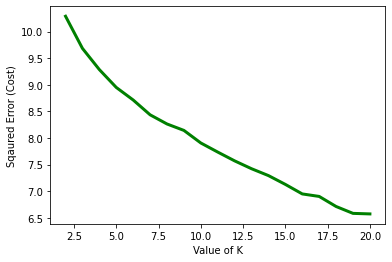

In [ ]:
# plot the Cost against K values for Elbow Method 
plt.plot(range(2, 21), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

This is the Elbow Method. If this line graph has a clear inflection point, such that the graph looks like a bent elbow, then the value of k associated with the inflection point is most desirable. 

Looking at the line graph of different values for k, there does not appear to be a very clear inflection point. Overall the inflection point appears as though it might be where k = 5.

#### Silhouette Score

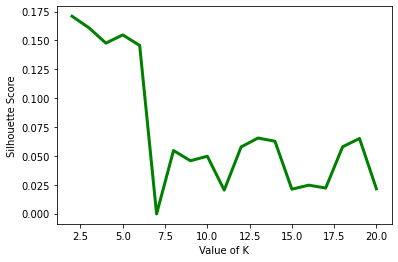

In [ ]:
# Plot the Silhouette score against K values 
plt.plot(range(2, 21), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette Score") 
plt.show() # clear the plot 

Based on the advice provided, a good Silhouette Score is 0.7. The advice also recommended the value of k for which the Silhouette Score is highest. In this case it would be for k = 2.

However, the Silhouette Scores for all values of k appear very low, compared to the 0.7 standard. Also, k = 2 is not in line with recommendations from the Elbow Method.

#### Davies Bouldin Index

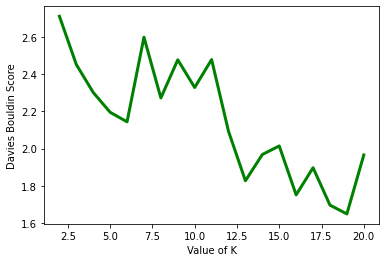

In [ ]:
# plot Davies Bouldin Score against K values 
plt.plot(range(2, 21), db, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Davies Bouldin Score") 
plt.show() # clear the plot 

Based on the advice provided, the value of k associated with the lowest Davies Bouldin Score is the best choice. However, given how erratic the graph appears, and the downward sloping nature of the graph, it appears the optimal value for k here would simply be as high as possible.

#### Best value for k

With the three different measures, there does not appear to be a strong consensus for an optimal value of k. 

The Silhouette Score would indicate 2 clusters, though that would not seem to be very helpful in capturing a variety of neighborhood types between the two cities. Similarly, as high a number of clusters as possible is not helpful either in determining clear patterns in the types of neighbourhoods clustered.

Thus the results of the Elbow Test will be used, despite there not being a clear answer there either. Thus k = 5 will be used, as per the previous exercises in this course.

#### Run k-means clustering

K-means clustering is run with 5 clusters here.

In [ ]:
# Set number of clusters
kclusters = 5

# Run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(grouped_clustering_5)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 3, 2, 3, 3, 2, 3, 0, 3], dtype=int32)

The cluster lables are added to the dataset and the dataset joined with the list of neighbourhoods in both cities. 

In [ ]:
# Add clustering labels
neighborhoods_venues_sorted_5.insert(0, 'Cluster Labels', kmeans.labels_)

nl_merged = df

# Merge to add latitude/longitude for each neighborhood
nl_merged_5 = nl_merged.join(neighborhoods_venues_sorted_5.set_index('Neighborhood'), on = 'Neighborhoods')

nl_merged_5.head()

,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Admiralenbuurt,52.369783,4.853039,Amsterdam,3.0,Bar,Café,Deli / Bodega,Restaurant,Coffee Shop
1,Amsteldorp,52.343155,4.930725,Amsterdam,2.0,Soccer Field,Sports Bar,Sports Club,French Restaurant,Fish & Chips Shop
2,Amsterdam Oud-West,52.364815,4.869762,Amsterdam,3.0,Café,Coffee Shop,Italian Restaurant,Bar,Restaurant
3,Amsterdam Oud-Zuid,52.339125,4.866185,Amsterdam,3.0,Coffee Shop,Salad Place,Sushi Restaurant,Electronics Store,Italian Restaurant
4,Amsterdam Science Park,52.352926,4.948315,Amsterdam,2.0,Soccer Field,Train Station,Indoor Play Area,Scandinavian Restaurant,Restaurant


However, neighbourhoods have been dropped from the clustered venue dataset whereas no neighbourhoods have been dropped from the original list of neighbourhoods.

Thus the neighbourhoods with fewer than 5 venues listed on Foursquare are dropped from this joined dataset as well.

In [ ]:
# Drop neighborhoods according to list in drop_5
print("Before dropping:", nl_merged_5.shape)
nl_merged_5 = nl_merged_5[~nl_merged_5['Neighborhoods'].isin(drop_5)]
print("After dropping:", nl_merged_5.shape)

Before dropping: (194, 10)
After dropping: (167, 10)


During a previous similar exercise in this course, I found that the clustering process excluded a few neighborhoods in Toronto, Canada. During the investigation then, I found that the Foursquare API was not providing venue data for some neighbourhoods. After checking Foursquare's website manually it became apparent that Foursquare did not have data on venues in those neighbourhoods.

This check is performed for the neighbourhoods in Amsterdam and Rotterdam as well. I do admit, in hindsight this step could have been done in the data preprocessing section earlier. But it has been done here now with no change to the results.

In [ ]:
# Check for neighborhoods with missing venue data
missing_5 = nl_merged_5[nl_merged_5.isna().any(axis = 1)]

print(missing_5.shape)
missing_5

(2, 10)


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
46,Landelijk Noord,52.402222,4.974167,Amsterdam,NaN,NaN,NaN,NaN,NaN,NaN
79,Vondelingenplaat,51.885711,4.352515,Rotterdam,NaN,NaN,NaN,NaN,NaN,NaN


It appears that 2 neighbourhoods listed in the original data from Wikipedia did not have any venue data associated with them on Foursquare's database. To confirm this, these 2 neighbourhoods were investigated further:

Landelijk Noord, Amsterdam: <br>
A look at Google Maps based on the coordinates of this neighbourhood shows an area quite far north of the centre of Amsterdam. <br>
https://www.google.nl/maps/place/52%C2%B024'08.0%22N+4%C2%B058'27.0%22E/@52.4038129,4.9421512,12.83z/data=!4m5!3m4!1s0x0:0x0!8m2!3d52.402222!4d4.974167 <br>
A search for this neighbourhood on Foursquare offers venues in Amsterdam Central and none where Google Maps indicates the neighbourhood is actually located. <br>
https://foursquare.com/explore?mode=url&near=Amsterdam%2C%20Netherlands&nearGeoId=72057594040687730&q=Landelijk%20Noord <br>
Thus we can conclude that Foursquare simply does not have relevant venue data for this neighbourhood.

Vondelingenplaat, Rotterdam: <br>
A search for this neighbourhood on Foursquare offers zero search results at the time of this exercise.
https://foursquare.com/explore?mode=url&near=Rotterdam%2C%20Netherlands&nearGeoId=72057594040675827&q=Vondelingenplaat


**Resolution**

Only 2 neighbourhoods are missing data and more have already been dropped previously. Therefore these 2 neighborhoods are also dropped from the clustering process.


In [ ]:
# Drop neighborhoods from dataframe
nl_merged_5 = nl_merged_5[nl_merged_5['1st Most Common Venue'].notna()]

# Convert Cluster Labels to integer
nl_merged_5['Cluster Labels'] = nl_merged_5['Cluster Labels'].astype(int)

# Display sample of dataframe
nl_merged_5.head()

,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Admiralenbuurt,52.369783,4.853039,Amsterdam,3,Bar,Café,Deli / Bodega,Restaurant,Coffee Shop
1,Amsteldorp,52.343155,4.930725,Amsterdam,2,Soccer Field,Sports Bar,Sports Club,French Restaurant,Fish & Chips Shop
2,Amsterdam Oud-West,52.364815,4.869762,Amsterdam,3,Café,Coffee Shop,Italian Restaurant,Bar,Restaurant
3,Amsterdam Oud-Zuid,52.339125,4.866185,Amsterdam,3,Coffee Shop,Salad Place,Sushi Restaurant,Electronics Store,Italian Restaurant
4,Amsterdam Science Park,52.352926,4.948315,Amsterdam,2,Soccer Field,Train Station,Indoor Play Area,Scandinavian Restaurant,Restaurant


### 5.2 Top 3 most common venues per neighbourhood

For k-means clustering, the appropriate number of clusters is yet to be determined. For the exercises completed previously for this IBM Data Science course, k was 5. 

Why, exactly? Honestly I could not figure that out. Here I will attempt to find a value for k appropriate to the data at hand. During lectures the Elbow Method was described, and a quick Google search has offered the Silhouette Score and Davies Bouldin Score as two other measures to determine how many clusters to use. I do note that the advice provided along with these measures was that these are simply rules of thumb, and the choice of k is still ultimately up to the data scientist, aka me. 

Now, scores are calculated for various values of k.

In [ ]:
## Testing how to find optimal k for k-means clustering
# https://gdcoder.com/silhouette-analysis-vs-elbow-method-vs-davies-bouldin-index-selecting-the-optimal-number-of-clusters-for-kmeans-clustering/

# Drop Neighborhood column
grouped_clustering_3 = grouped_3.drop('Neighborhood', 1)

cost = [] 
sil = []
db = [] 

for i in range(2, 21): 
    KM = KMeans(n_clusters = i, max_iter = 500).fit(grouped_clustering_3)  
    
    cost.append(KM.inertia_)
    sil.append(silhouette_score(grouped_clustering_3, KM.labels_, metric = 'euclidean'))    
    db.append(davies_bouldin_score(grouped_clustering_3, KM.labels_))  

#### The Elbow Method

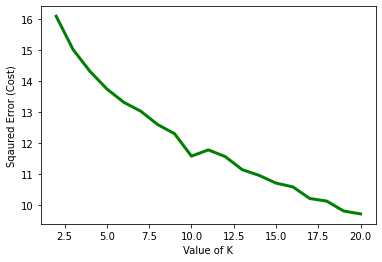

In [ ]:
# plot the Cost against K values for Elbow Method 
plt.plot(range(2, 21), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

This is the Elbow Method. If this line graph has a clear inflection point, such that the graph looks like a bent elbow, then the value of k associated with the inflection point is most desirable. 

Looking at the line graph of different values for k, there does not appear to be a very clear inflection point. Overall the inflection point might be where k = 5. I also do note that strangely, there is a dip in the line graph where k is around 9 or 10.

#### Silhouette Score

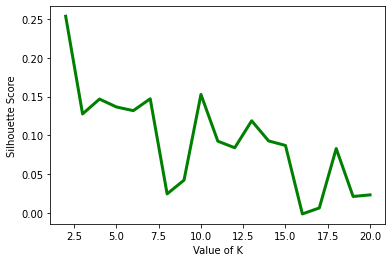

In [ ]:
# Plot the Silhouette score against K values 
plt.plot(range(2, 21), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette Score") 
plt.show() # clear the plot 

Based on the advice provided, a good Silhouette Score is 0.7. The advice also recommended the value of k for which the Silhouette Score is highest. In this case it would be for k = 2.

However, the Silhouette Scores for all values of k appear very low, compared to the 0.7 standard. Also, k = 2 is not in line with recommendations from the Elbow Method.

#### Davies Bouldin Index

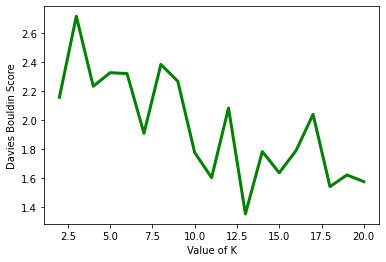

In [ ]:
# plot Davies Bouldin Score against K values 
plt.plot(range(2, 21), db, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Davies Bouldin Score") 
plt.show() # clear the plot 

Based on the advice provided, the value of k associated with the lowest Davies Bouldin Score is the best choice. Here that seems to be 13. However, given how erratic the graph appears, and the downward sloping nature of the graph, it appears the optimal value for k here would simply be as high as possible.

#### Best value for k

With the three different measures, there does not appear to be a strong consensus for an optimal value of k. 

The Silhouette Score would indicate 2 clusters, though that would not seem to be very helpful in capturing a variety of neighbourhood types between the two cities. Similarly, as high a number of clusters as possible is not helpful either in determining clear patterns in the types of neighborhoods clustered.

Thus the results of the Elbow Test will be used, despite there not being a clear answer there either. Thus k = 5 will be used, as per the previous exercises in this course.

#### Run k-means clustering

K-means clustering is run with 5 clusters here.

In [ ]:
# Set number of clusters
kclusters = 5

# Run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(grouped_clustering_3)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 2, 0, 2, 2, 2, 2, 0], dtype=int32)

The cluster lables are added to the dataset and the dataset joined with the list of neighbourhoods in both cities. 

In [ ]:
# Add clustering labels
neighborhoods_venues_sorted_3.insert(0, 'Cluster Labels', kmeans.labels_)

nl_merged = df

# Merge to add latitude/longitude for each neighborhood
nl_merged_3 = nl_merged.join(neighborhoods_venues_sorted_3.set_index('Neighborhood'), on = 'Neighborhoods')

nl_merged_3.head()

,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Admiralenbuurt,52.369783,4.853039,Amsterdam,2.0,Bar,Café,Deli / Bodega
1,Amsteldorp,52.343155,4.930725,Amsterdam,0.0,Soccer Field,Sports Bar,Sports Club
2,Amsterdam Oud-West,52.364815,4.869762,Amsterdam,2.0,Café,Coffee Shop,Italian Restaurant
3,Amsterdam Oud-Zuid,52.339125,4.866185,Amsterdam,2.0,Coffee Shop,Salad Place,Sushi Restaurant
4,Amsterdam Science Park,52.352926,4.948315,Amsterdam,2.0,Soccer Field,Train Station,Indoor Play Area


However, neighbourhoods have been dropped from the clustered venue dataset whereas no neighbourhoods have been dropped from the original list of neighborhoods.

Thus the neighbourhoods with fewer than 3 venues listed on Foursquare are dropped from this joined dataset as well.

In [ ]:
# Drop neighborhoods according to list in drop_3
print("Before dropping:", nl_merged_3.shape)
nl_merged_3 = nl_merged_3[~nl_merged_3['Neighborhoods'].isin(drop_3)]
print("After dropping:", nl_merged_3.shape)

Before dropping: (194, 8)
After dropping: (187, 8)


From the process applied for the top 5 most common venues, 2 neighbourhoods from the lists on Wikipedia did not have any venue data on Foursquare.

These 2 neighbourhoods are as follows:

In [ ]:
# Check for neighborhoods with missing venue data
missing_3 = nl_merged_3[nl_merged_3.isna().any(axis = 1)]

print(missing_3.shape)
missing_3

(2, 8)


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
46,Landelijk Noord,52.402222,4.974167,Amsterdam,NaN,NaN,NaN,NaN
79,Vondelingenplaat,51.885711,4.352515,Rotterdam,NaN,NaN,NaN,NaN


As with the process for the top 5 most common venues, these two neighbourhoods are dropped.


In [ ]:
# Drop neighborhoods from dataframe
nl_merged_3 = nl_merged_3[nl_merged_3['1st Most Common Venue'].notna()]

# Convert Cluster Labels to integer
nl_merged_3['Cluster Labels'] = nl_merged_3['Cluster Labels'].astype(int)

# Display sample of dataframe
nl_merged_3.head()

,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Admiralenbuurt,52.369783,4.853039,Amsterdam,2,Bar,Café,Deli / Bodega
1,Amsteldorp,52.343155,4.930725,Amsterdam,0,Soccer Field,Sports Bar,Sports Club
2,Amsterdam Oud-West,52.364815,4.869762,Amsterdam,2,Café,Coffee Shop,Italian Restaurant
3,Amsterdam Oud-Zuid,52.339125,4.866185,Amsterdam,2,Coffee Shop,Salad Place,Sushi Restaurant
4,Amsterdam Science Park,52.352926,4.948315,Amsterdam,2,Soccer Field,Train Station,Indoor Play Area


# 6. Results<a name="s6"></a>

Finally the results of the clustering process can be shown. 

### 6.1 Results using top 5 most common venues

#### Maps of Amsterdam and Rotterdam

The colours for clusters on the map of Amsterdam correspond to the colours for the clusters on the map of Rotterdam. As an example, a purple dot on the Amsterdam map is in the same cluster as a purple dot on the Rotterdam map.

For convenience, two maps are displayed, one for each city. However, zooming out on either map will show the clusters for both cities. 

First, a map of Amsterdam:

In [ ]:
# Create map for Amsterdam
map_clusters = folium.Map(location = [latitude_am, longitude_am], width = '100%', height = '100%', zoom_start = 11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nl_merged_5['Latitude'], nl_merged_5['Longitude'], nl_merged_5['Neighborhoods'], nl_merged_5['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

Second, a map of Rotterdam.

In [ ]:
# Create map for Rotterdam
map_clusters2 = folium.Map(location = [latitude_ro, longitude_ro], width = '100%', height = '100%', zoom_start = 11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nl_merged_5['Latitude'], nl_merged_5['Longitude'], nl_merged_5['Neighborhoods'], nl_merged_5['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters2)
       
map_clusters2

Based on these 2 maps, it appears there are indeed some similarities between the neighbourhoods in Amsterdam and Rotterdam. The green neighbourhoods (cluster 3) tend to be located in the city centre, while the others tend to be outside the city centre.

One point of difference is that Amsterdam seems to have significantly more green neighbourhoods than other types of neighborhoods, compared to Rotterdam.

#### Interpretation of Cluster Results

**Cluster 0 - Red - Supermarket Land**

In [ ]:
# Display cluster 0
cluster_0 = nl_merged_5.loc[nl_merged_5['Cluster Labels'] == 0]
print('Cluster 0 contains', len(cluster_0.index), 'neighborhoods.')
cluster_0

Cluster 0 contains 45 neighborhoods.


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Buikslotermeer,52.399439,4.943135,Amsterdam,0,Supermarket,Sandwich Place,Brasserie,Drugstore,Restaurant
20,De Aker,52.350632,4.783183,Amsterdam,0,Tram Station,Bakery,Fish & Chips Shop,Drugstore,Pizza Place
30,Geuzenveld,52.378394,4.801628,Amsterdam,0,Supermarket,Tram Station,Grocery Store,Turkish Restaurant,Plaza
49,Middelveldsche Akerpolder,52.347000,4.788300,Amsterdam,0,Bakery,Bed & Breakfast,Pizza Place,Cheese Shop,Supermarket
54,Nieuw Sloten,52.346524,4.811527,Amsterdam,0,Tram Station,Flower Shop,Bakery,Drugstore,Supermarket
56,Nieuwendam,52.394472,4.953412,Amsterdam,0,Supermarket,Bakery,Snack Place,Grocery Store,Bus Stop
66,Osdorp,52.356619,4.799164,Amsterdam,0,Supermarket,Snack Place,Turkish Restaurant,Bakery,Coffee Shop
72,Overtoomse Veld,52.361541,4.839751,Amsterdam,0,Supermarket,Bakery,Juice Bar,Lawyer,Drugstore
76,Rieteilanden,52.354100,4.993600,Amsterdam,0,Italian Restaurant,Asian Restaurant,Farmers Market,Beach,Bagel Shop
94,Watergraafsmeer,52.349809,4.938299,Amsterdam,0,Fast Food Restaurant,Stadium,Playground,Supermarket,Restaurant


Cluster 0 seems to be dominated by supermarkets and shops. For most of these neighbourhoods, the most common venue type is supermarket. 

Additionally, most of these neighbourhoods are in Rotterdam.

**Cluster 1 - Purple - Public Transport Land**

In [ ]:
# Display cluster 1
cluster_1 = nl_merged_5.loc[nl_merged_5['Cluster Labels'] == 1]
print('Cluster 1 contains', len(cluster_1.index), 'neighborhoods.')
cluster_1

Cluster 1 contains 9 neighborhoods.


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
65,Oostzanerwerf,52.419487,4.889508,Amsterdam,1,Bus Stop,Supermarket,Gym / Fitness Center,Bookstore,Furniture / Home Store
102,Zeeburgereiland,52.372608,4.965546,Amsterdam,1,Bus Stop,Tram Station,Café,Supermarket,Harbor / Marina
10,Carnisserbuurt,51.888000,4.479400,Rotterdam,1,Pool Hall,Resort,Supermarket,Bus Stop,Greek Restaurant
18,Groenenhagen-Tuinenhoven,51.890921,4.552172,Rotterdam,1,Bus Stop,Tram Station,Supermarket,Fast Food Restaurant,Farmers Market
45,Molièrebuurt,51.873556,4.520315,Rotterdam,1,Supermarket,Bus Stop,Basketball Court,Intersection,Park
47,Nieuw Engeland,51.871552,4.350809,Rotterdam,1,Bus Stop,Food & Drink Shop,Caribbean Restaurant,Supermarket,Farm
56,Oud-Mathenesse,51.916548,4.420908,Rotterdam,1,Bus Stop,Tram Station,Supermarket,Chinese Restaurant,Pizza Place
64,Reyeroord,51.881079,4.555340,Rotterdam,1,Tram Station,Bus Stop,Pizza Place,Sports Bar,Trail
84,Witte Dorp,51.914994,4.425384,Rotterdam,1,Bus Stop,Bus Station,Chinese Restaurant,Pizza Place,Fast Food Restaurant


Cluster 1 seems to be dominated by public transport. Bus stops and tram stations are the most common type of venue for most neighbourhoods in this cluster.

**Cluster 2 - Blue - Sportstopia**

In [ ]:
# Display cluster 2
cluster_2 = nl_merged_5.loc[nl_merged_5['Cluster Labels'] == 2]
print('Cluster 2 contains', len(cluster_2.index), 'neighborhoods.')
cluster_2

Cluster 2 contains 3 neighborhoods.


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Amsteldorp,52.343155,4.930725,Amsterdam,2,Soccer Field,Sports Bar,Sports Club,French Restaurant,Fish & Chips Shop
4,Amsterdam Science Park,52.352926,4.948315,Amsterdam,2,Soccer Field,Train Station,Indoor Play Area,Scandinavian Restaurant,Restaurant
35,Kreekhuizen,51.884303,4.534143,Rotterdam,2,Café,Platform,Soccer Field,Plaza,Tram Station


For two of these neighbourhoods, the most common venue is a soccer field. For the other, a soccer field is the 3rd most common venue.

**Cluster 3 - Green - Social City Centre**

In [ ]:
# Display cluster 3
cluster_3 = nl_merged_5.loc[nl_merged_5['Cluster Labels'] == 3]
print('Cluster 3 contains', len(cluster_3.index), 'neighborhoods.')
cluster_3

Cluster 3 contains 97 neighborhoods.


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Admiralenbuurt,52.369783,4.853039,Amsterdam,3,Bar,Café,Deli / Bodega,Restaurant,Coffee Shop
2,Amsterdam Oud-West,52.364815,4.869762,Amsterdam,3,Café,Coffee Shop,Italian Restaurant,Bar,Restaurant
3,Amsterdam Oud-Zuid,52.339125,4.866185,Amsterdam,3,Coffee Shop,Salad Place,Sushi Restaurant,Electronics Store,Italian Restaurant
5,Apollobuurt,52.348073,4.875559,Amsterdam,3,Hotel,Ice Cream Shop,Arts & Crafts Store,Café,Steakhouse
8,Binnenstad (Amsterdam),52.372000,4.896000,Amsterdam,3,Bar,Hotel,Coffee Shop,Café,Dessert Shop
...,...,...,...,...,...,...,...,...,...,...
67,Scheepvaartkwartier,51.909200,4.478700,Rotterdam,3,Restaurant,French Restaurant,Hotel,Tram Station,Pub
71,Spaanse Polder,51.929811,4.409066,Rotterdam,3,Motorcycle Shop,Fast Food Restaurant,Café,Ski Area,Big Box Store
74,Stadsdriehoek,51.921768,4.486689,Rotterdam,3,Bar,Italian Restaurant,Café,Restaurant,Vegetarian / Vegan Restaurant
75,Struisenburg,51.918983,4.507834,Rotterdam,3,Bar,Pool,Tapas Restaurant,Hotel,Italian Restaurant


Cluster 3 seems to be dominated by bars, cafes and restaurants.


**Cluster 4 - Orange - Cosmopolitan Countryside**

In [ ]:
# Display cluster 4
cluster_4 = nl_merged_5.loc[nl_merged_5['Cluster Labels'] == 4]
print('Cluster 5 contains', len(cluster_4.index), 'neighborhoods.')
cluster_4

Cluster 5 contains 11 neighborhoods.


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Buiksloot,52.392562,4.929279,Amsterdam,4,Bakery,Bus Stop,Campground,Park,Health & Beauty Service
26,Eendracht (Amsterdam),52.380762,4.790498,Amsterdam,4,Soccer Field,Baseball Field,Park,Snack Place,General Entertainment
29,Gaasperdam,52.307581,4.971503,Amsterdam,4,Park,Harbor / Marina,Track,Playground,Nightclub
50,Molenwijk (Amsterdam),52.416244,4.892754,Amsterdam,4,Pharmacy,Supermarket,Plaza,Bus Stop,Soccer Field
57,Nieuwendammerdijk en Buiksloterdijk,52.389400,4.941000,Amsterdam,4,Bus Stop,Smoke Shop,Snack Place,Harbor / Marina,Tennis Court
90,Tuindorp Nieuwendam,52.390470,4.946901,Amsterdam,4,Pharmacy,Smoke Shop,Indonesian Restaurant,Plaza,Park
91,Tuindorp Oostzaan,52.412796,4.888052,Amsterdam,4,Bus Stop,Motorcycle Shop,Plaza,Baseball Field,Business Service
11,Charlois,51.883570,4.477813,Rotterdam,4,Dog Run,Park,Bakery,Jazz Club,Bus Stop
25,Hordijkerveld,51.878563,4.545690,Rotterdam,4,Snack Place,Park,Shopping Mall,Dog Run,Gaming Cafe
36,Landzicht,51.945439,4.430210,Rotterdam,4,Airport,Bus Stop,Snack Place,Hotel,Bookstore


Cluster 4 appears quite diverse. Many neighbourhoods have various restaurants and supermarkets as the most common venue types. Compared to the other clusters, this clusters seems to be a mix of Cluster 0's Supermarket Land and Cluster 1's Social City Centre.

Based on the maps of the cities, it appears that the neighbourhoods in Cluster 4 (orange) tend to be the ones on the outskirts of the city.

### 6.1 Results using top 3 most common venues

#### Maps of Amsterdam and Rotterdam

The colours for clusters on the map of Amsterdam correspond to the colours for the clusters on the map of Rotterdam. As an example, a purple dot on the Amsterdam map is in the same cluster as a purple dot on the Rotterdam map.

For convenience, two maps are displayed, one for each city. However, zooming out on eith map will show the clusters for both cities. 

First, a map of Amsterdam:

In [ ]:
# Create map for Amsterdam
map_clusters = folium.Map(location = [latitude_am, longitude_am], width = '100%', height = '100%', zoom_start = 11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nl_merged_3['Latitude'], nl_merged_3['Longitude'], nl_merged_3['Neighborhoods'], nl_merged_3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

Second, a map of Rotterdam.

In [ ]:
# Create map for Rotterdam
map_clusters2 = folium.Map(location = [latitude_ro, longitude_ro], width = '100%', height = '100%', zoom_start = 11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nl_merged_3['Latitude'], nl_merged_3['Longitude'], nl_merged_3['Neighborhoods'], nl_merged_3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters2)
       
map_clusters2

Based on these 2 maps, it appears there are indeed some similarities between the neighbourhoods in Amsterdam and Rotterdam. The purple and orange neighbourhoods (clusters 1 and 4) tend to be located in the city centre. Similarly the red, blue and green neighbourhoods (clusters 0, 2, 3) tend to be more on the outskirts of the respective cities.

One point of difference is that Amsterdam seems to have signifincatly more purple neighbourhoods than other types of neighbourhoods, compared to Rotterdam.

#### Interpretation of Cluster Results

**Cluster 0 - Red - Supermarket Land**

In [ ]:
# Display cluster 0
cluster_0 = nl_merged_3.loc[nl_merged_3['Cluster Labels'] == 0]
print('Cluster 0 contains', len(cluster_0.index), 'neighborhoods.')
cluster_0

Cluster 0 contains 55 neighborhoods.


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Amsteldorp,52.343155,4.930725,Amsterdam,0,Soccer Field,Sports Bar,Sports Club
10,Buiksloot,52.392562,4.929279,Amsterdam,0,Bakery,Bus Stop,Campground
11,Buikslotermeer,52.399439,4.943135,Amsterdam,0,Supermarket,Sandwich Place,Brasserie
26,Eendracht (Amsterdam),52.380762,4.790498,Amsterdam,0,Soccer Field,Baseball Field,Park
27,Floradorp,52.398532,4.914832,Amsterdam,0,Furniture / Home Store,Park,Pool
42,Kadoelen,52.416447,4.899304,Amsterdam,0,Supermarket,Restaurant,Soccer Field
45,Kolenkit District,52.378611,4.841389,Amsterdam,0,Turkish Restaurant,Plaza,Park
49,Middelveldsche Akerpolder,52.347000,4.788300,Amsterdam,0,Bakery,Bed & Breakfast,Pizza Place
50,Molenwijk (Amsterdam),52.416244,4.892754,Amsterdam,0,Pharmacy,Supermarket,Plaza
56,Nieuwendam,52.394472,4.953412,Amsterdam,0,Supermarket,Bakery,Snack Place


Cluster 0 seems to be dominated by supermarkets and shops. For most of these neighbourhoods, the most common venue type is supermarket.  Additionally, most of these neighbourhoods are in Rotterdam.

However, compared to the clustering for the top 5 most common venue types, it appears this cluster appears a bit less clear. Yes, most of these neighbourhoods here have supermarkets as their most common venue type. Yet, a few do not seem to have supermarkets or shops of any kind in their top 3 most common venue types.

**Cluster 1 - Purple - Public Transport Land**

In [ ]:
# Display cluster 1
cluster_1 = nl_merged_3.loc[nl_merged_3['Cluster Labels'] == 1]
print('Cluster 1 contains', len(cluster_1.index), 'neighborhoods.')
cluster_1

Cluster 1 contains 16 neighborhoods.


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
17,Cruquiuseiland,52.370395,4.954212,Amsterdam,1,Lounge,Pub,Harbor / Marina
57,Nieuwendammerdijk en Buiksloterdijk,52.389400,4.941000,Amsterdam,1,Bus Stop,Smoke Shop,Snack Place
65,Oostzanerwerf,52.419487,4.889508,Amsterdam,1,Bus Stop,Supermarket,Gym / Fitness Center
91,Tuindorp Oostzaan,52.412796,4.888052,Amsterdam,1,Bus Stop,Motorcycle Shop,Plaza
102,Zeeburgereiland,52.372608,4.965546,Amsterdam,1,Bus Stop,Tram Station,Café
4,Beverwaard,51.894349,4.570543,Rotterdam,1,Metro Station,Bus Stop,Tram Station
18,Groenenhagen-Tuinenhoven,51.890921,4.552172,Rotterdam,1,Bus Stop,Tram Station,Supermarket
47,Nieuw Engeland,51.871552,4.350809,Rotterdam,1,Bus Stop,Food & Drink Shop,Caribbean Restaurant
54,Oud-Charlois,51.888905,4.466292,Rotterdam,1,Bus Stop,Gym,Zoo Exhibit
56,Oud-Mathenesse,51.916548,4.420908,Rotterdam,1,Bus Stop,Tram Station,Supermarket


Cluster 1 seems to be dominated by public transport. Bus stops and tram stations are the most common type of venue for most neighbourhoods in this cluster.

Yet, as with Cluster 0, there appear to be more neighbourhoods where public transport is not in the top 3 most common venue types. For example, Cruquiuseiland in Amsterdam has more lounges, pubs and harbors/marinas.

**Cluster 2 - Blue - Social City Centre**

In [ ]:
# Display cluster 2
cluster_2 = nl_merged_3.loc[nl_merged_3['Cluster Labels'] == 2]
print('Cluster 2 contains', len(cluster_2.index), 'neighborhoods.')
cluster_2

Cluster 2 contains 96 neighborhoods.


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Admiralenbuurt,52.369783,4.853039,Amsterdam,2,Bar,Café,Deli / Bodega
2,Amsterdam Oud-West,52.364815,4.869762,Amsterdam,2,Café,Coffee Shop,Italian Restaurant
3,Amsterdam Oud-Zuid,52.339125,4.866185,Amsterdam,2,Coffee Shop,Salad Place,Sushi Restaurant
4,Amsterdam Science Park,52.352926,4.948315,Amsterdam,2,Soccer Field,Train Station,Indoor Play Area
5,Apollobuurt,52.348073,4.875559,Amsterdam,2,Hotel,Ice Cream Shop,Arts & Crafts Store
...,...,...,...,...,...,...,...,...
67,Scheepvaartkwartier,51.909200,4.478700,Rotterdam,2,Restaurant,French Restaurant,Hotel
71,Spaanse Polder,51.929811,4.409066,Rotterdam,2,Motorcycle Shop,Fast Food Restaurant,Café
74,Stadsdriehoek,51.921768,4.486689,Rotterdam,2,Bar,Italian Restaurant,Café
75,Struisenburg,51.918983,4.507834,Rotterdam,2,Bar,Pool,Tapas Restaurant


Cluster 2 seems to be dominated by bars, cafes and restaurants.

As with the previous clusters, the relationship does not appear quite as strong.

**Cluster 3 - Green - Tram Station Land**

In [ ]:
# Display cluster 3
cluster_3 = nl_merged_3.loc[nl_merged_3['Cluster Labels'] == 3]
print('Cluster 3 contains', len(cluster_3.index), 'neighborhoods.')
cluster_3

Cluster 3 contains 15 neighborhoods.


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
20,De Aker,52.350632,4.783183,Amsterdam,3,Tram Station,Bakery,Fish & Chips Shop
30,Geuzenveld,52.378394,4.801628,Amsterdam,3,Supermarket,Tram Station,Grocery Store
54,Nieuw Sloten,52.346524,4.811527,Amsterdam,3,Tram Station,Flower Shop,Bakery
63,Oostoever,52.366292,4.830367,Amsterdam,3,Indian Chinese Restaurant,Nightclub,Tram Station
6,"Bloemhof, Rotterdam",51.894570,4.499457,Rotterdam,3,Tram Station,Italian Restaurant,Turkish Restaurant
14,De Esch,51.911482,4.521211,Rotterdam,3,Tram Station,Supermarket,Concert Hall
17,Feijenoord (neighbourhood),51.894900,4.513900,Rotterdam,3,Fast Food Restaurant,Supermarket,Tram Station
48,Nieuw-Mathenesse,51.910159,4.425945,Rotterdam,3,Tram Station,Turkish Restaurant,Garden
64,Reyeroord,51.881079,4.555340,Rotterdam,3,Tram Station,Bus Stop,Pizza Place
69,Schiemond,51.902827,4.450577,Rotterdam,3,Bar,Harbor / Marina,Light Rail Station



This is suprising. There appears to be another cluster around public transport. In almost every neighbourhood here, tram stations are in the top 3 most common venue types. The one exception is Schiemond, where light rail stations are the 3rd most common venue type. 

**Cluster 4 - Orange - Park Park**

In [ ]:
# Display cluster 4
cluster_4 = nl_merged_3.loc[nl_merged_3['Cluster Labels'] == 4]
print('Cluster 5 contains', len(cluster_4.index), 'neighborhoods.')
cluster_4

Cluster 5 contains 3 neighborhoods.


,Neighborhoods,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
7,Bijlmermeer,52.317033,4.964991,Amsterdam,4,Park,Theater,Empanada Restaurant
29,Gaasperdam,52.307581,4.971503,Amsterdam,4,Park,Harbor / Marina,Track
55,Oud-IJsselmonde,51.898826,4.536927,Rotterdam,4,Outdoor Supply Store,IT Services,Park


All the neighbourhoods in this cluster have a park as their top three most common venue type.

## 6.3 Conclusions

There were a few differences in the results of k-means clustering for top 5 and top 3 most common venue types per neighbourhood. However, the core findings appear to have strong similarities.

As mentioned at the start of this notebook, the questions to answer are:

1. How similar is Rotterdam to Amsterdam?
2. Would I enjoy living in Rotterdam?
3. Based on my experience in Amsterdam neighbourhoods, which neighbourhoods in Rotterdam would I enjoy living in?

After the analysis we can attempt to answer these questions.

1. How similar is Rotterdam to Amsterdam?
Overall, the neighbourhoods in Rotterdam appear to share many similarities with Amsterdam. If this were not the case, the clusters would only include neighbourhoods in one city. This was not the case, where most clusters included a fairly even balance of neighborhoods between the 2 cities. 

The large exception is the cluster (the Social City Centre) associated with bars, cafes and coffee shops. Amsterdam appeared to have many more neighbourhoods like this compared to Rotterdam. But, based on my experiences with Amsterdam, this makes perfect sense, since Amsterdam is a large tourist destination, so many more neighbourhoods cater to those more touristy lifestyles, ie drinking at bars, relaxing at cafes, and smoking at coffee shops.

2. Would I enjoy living in Rotterdam?
Considering that overall, Rotterdam appears fairly similar to Amsterdam, I would probably enjoy living in Rotterdam too.

3. Based on my experience in Amsterdam neighbourhoods, which neighbourhoods in Rotterdam would I enjoy living in?
For my year in Amsterdam I lived on the outskirts, where there was plenty of outdoor space and nature, and also easy access to many shops. There was a train station nearby too.

By taking the types of clusters around where I lived in Amsterdam and comparing them to different parts of Rotterdam,  I can find an area in Rotterdam with a similar composition of cluster types. That way I can find a group of neighbourhoods similar to the place I lived in when I was in Amsterdam.

According to the results for the top 5 most common venue types, the best place for me to live in Rotterdam would be Kreekhuizen. A closer look at Kreekhuizen on a map reveals a beautiful large park a block away. The park is so beautiful I don't even need to see photos of it to know it's beautiful. (Look at the map and you will likely see what I mean.) There are also many many sportsfields nearby and even a large train station. Honestly this location does look really nice, and I am surprised by the helpfulness of this exercise.

According to the results for the top 5 most common venue type, the best place for me to live in Rotterdam would be Oud-IJsselmonde. Suprisingly this neighbourhood is quite close to Kreekhuizen, 2 kilometers away by bicycle. This neighbourhood is on the banks of the river Nieuwe Maas. There is a nature preserve island in this neighborhood too. 

Overall I think I would be happy to live in either neighbourhood recommended by this process and quite enjoyed working on this project.

